In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import itertools
import random
import json
import os

# Load data

In [2]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [3]:
flist = s3.glob('s3://jec-data/test/*.root')

In [4]:
from utils.config import DataConfig

data_config = DataConfig.load('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn.yaml')

In [5]:
from utils.fileio import read_files

table = read_files(flist, data_config.load_branches, s3)

In [6]:
from utils.preprocess import build_new_variables, finalize_inputs

# define new variables
build_new_variables(table, data_config.var_funcs)
# perform input variable standardization, clipping, padding and stacking
finalize_inputs(table, data_config)

In [7]:
input_data = {}
for key in table:
    if key.startswith('_'):
        input_data[key[1:]] = table[key]

In [8]:
for key in input_data:
    print(key, input_data[key].shape)

ch_features (100000, 3, 64)
ch_mask (100000, 1, 64)
ne_features (100000, 3, 64)
ne_mask (100000, 1, 64)
sv_features (100000, 3, 16)
sv_mask (100000, 1, 16)
jet_features (100000, 3)


In [9]:
observers = ak.to_pandas({k: table[k] for k in table if not k.startswith('_')})

In [10]:
observers.head()

,hadron_flavor,pt,pt_full_corr,pt_gen,eta_gen,parton_flavor,target
entry,,,,,,,
0,4.0,465.587006,492.745117,524.282104,0.093595,4.0,0.118731
1,0.0,143.126617,152.499039,148.415344,-1.139733,1.0,0.036285
2,0.0,5.100249,3.902844,4.922184,-0.544774,0.0,-0.035537
3,5.0,911.762024,965.063171,964.893127,0.141738,5.0,0.056638
4,4.0,474.884918,510.981354,526.357727,0.846466,-4.0,0.102909


In [11]:
data_len = observers.shape[0]

# Triton inference

### Set up client

In [12]:
import tritonclient.http as httpclient

triton_client = httpclient.InferenceServerClient(url='pfn-regressor-e9a91f.dholmber.svc.cluster.local', verbose=False)

In [13]:
def infer(inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype="FP32"))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

### Initialize inference experiment parameters

In [14]:
num_repeats = 10
batch_sizes = range(10, 1010, 10)
batch_stats = {batch_size: {'inference_time': [], 'inference_count': 0, 'total_inference_time': 0} for batch_size in batch_sizes}

### Retrieve initial inference time

In [15]:
statistics = triton_client.get_inference_statistics(model_name='optimal')
initial_batch_stats = statistics['model_stats'][0]['batch_stats']

for initial_stat in initial_batch_stats:
    batch_size = initial_stat['batch_size']
    if batch_size in batch_sizes:
        initial_inference = initial_stat['compute_infer']
        batch_stats[batch_size]['total_inference_time'] = initial_inference['ns']

### Gather statistics

In [16]:
for batch_size in tqdm(batch_sizes):
    while batch_stats[batch_size]['inference_count'] < num_repeats:
        indices = random.sample(range(data_len), batch_size)
        inputs = {}
        for key in input_data:
            inputs[key] = input_data[key][indices]

        results = infer(inputs)

        statistics = triton_client.get_inference_statistics(model_name='optimal')
        all_current_batch_stats = statistics['model_stats'][0]['batch_stats']
        for stat in all_current_batch_stats:
            if stat['batch_size'] == batch_size:
                current_batch = stat
                break

        last_inference_time = current_batch['compute_infer']['ns'] - batch_stats[batch_size]['total_inference_time']

        batch_stats[batch_size]['inference_time'].append(last_inference_time / batch_size)
        batch_stats[batch_size]['total_inference_time'] = current_batch['compute_infer']['ns']
        batch_stats[batch_size]['inference_count'] += 1

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


### Calculate metrics

In [17]:
y = []
yerr = []
for batch_size in batch_sizes:
    batch_inference_time = [t / 1000 for t in batch_stats[batch_size]['inference_time']]
    
    summed_time = sum(batch_inference_time)
    count = batch_stats[batch_size]['inference_count']
    if not count:
        continue

    mean_time = summed_time / count
    y.append(mean_time)
    
    sem = np.std(batch_inference_time, ddof=1) / np.sqrt(np.size(batch_inference_time))
    yerr.append(sem)

### Plot inference time

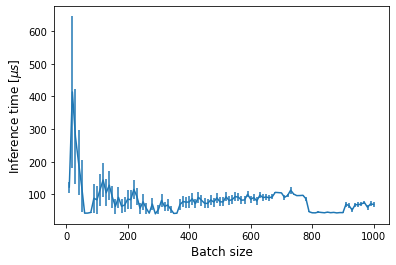

In [18]:
plt.errorbar(x=batch_sizes[:len(y)], y=y, yerr=yerr)
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Inference time [$\mu s$]', fontsize=12)
plt.savefig('inference_time.png')
plt.show()

# Physics results

In [14]:
batch_size = 1000

In [15]:
predictions = []

for i in tqdm(range(0, data_len, batch_size)):
    inputs = {}
    for key in input_data:
        inputs[key] = input_data[key][i:i+batch_size]

    results = infer(inputs)
    
    predictions.append(results.as_numpy(name='output'))
    
predictions = np.concatenate(predictions)

100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


In [16]:
predictions.shape

(100000, 1)

In [17]:
outdir = 'figs'
network_names = ['PFN']
names = ['Standard'] + network_names
preds = {'PFN': predictions.squeeze()}

In [18]:
df = observers
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))
df['Standard'] = df.pt_full_corr / df.pt_gen
for name in network_names:
    corrected_pt = np.exp(preds[name]) * df.pt
    df[name] = corrected_pt / df.pt_gen

In [19]:
try:
    os.makedirs(outdir)
except FileExistsError:
    pass

for subdir in ['distributions', 'flavours', 'response', 'resolution', 'residual']:
    try:
        for ext in ['png', 'pdf']:
            os.makedirs(os.path.join(outdir, subdir, ext))
    except FileExistsError:
        pass

In [20]:
binning = np.geomspace(20, 3000, 20)
bin_centers = np.sqrt(binning[:-1] * binning[1:])

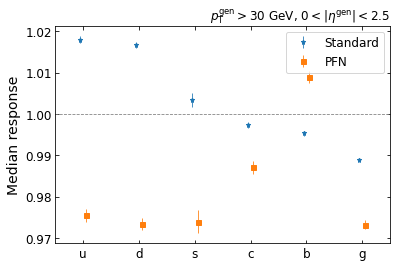

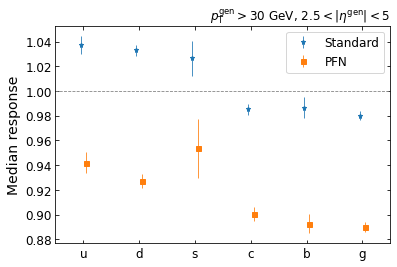

In [21]:
from utils.plot import compare_flavours

compare_flavours(df, names, os.path.join(outdir, 'flavours'))

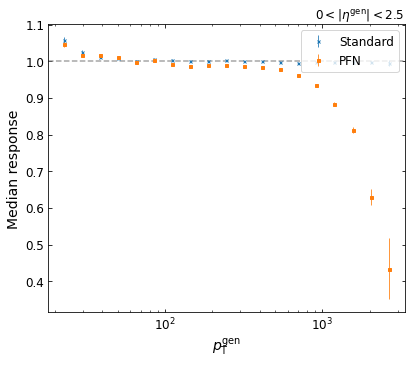

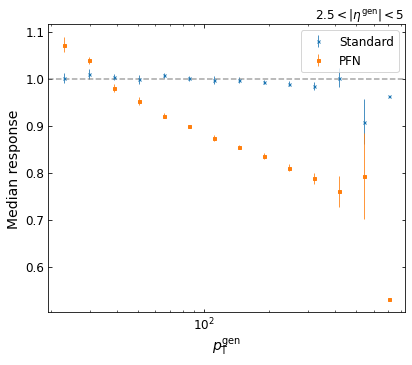

In [25]:
from utils.plot import plot_median_response

for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    plot_median_response(
        os.path.join(outdir, 'response'),
        flavour_label, bins, bin_centers, eta_bin, ieta, names
    )

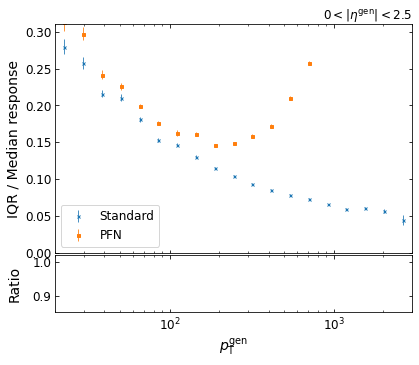

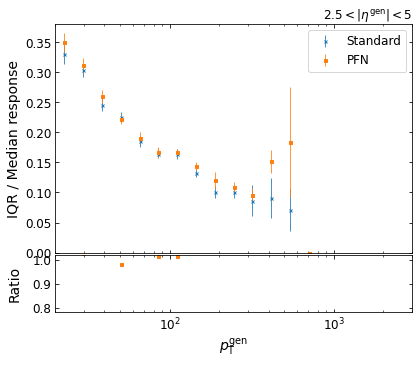

In [26]:
from utils.plot import plot_resolution, compute_resolution_improvement, to_serializable

data = {}
for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    data[f'{flavour_label}_eta{ieta}'] = plot_resolution(
        os.path.join(outdir, 'resolution'),
        flavour_label, bins, bin_centers, eta_bin, ieta, binning, names
    )

    for (ipt, pt_bin) in enumerate(
            [(30, np.inf), (30, 50), (50, 100), (100, 300), (300, 1000), (1000, np.inf)], start=1
        ):
        pt_bin = df_bin[
            (df_bin.pt_gen >= pt_bin[0])
            & (df_bin.pt_gen < pt_bin[1])
        ]
        data[f'{flavour_label}_eta{ieta}']['improvement'][f'pt{ipt}'] = compute_resolution_improvement(pt_bin, names)

with open(os.path.join(outdir, 'resolution', 'data.json'), 'w') as f:
    json.dump(data, f, indent='\t', default=to_serializable)

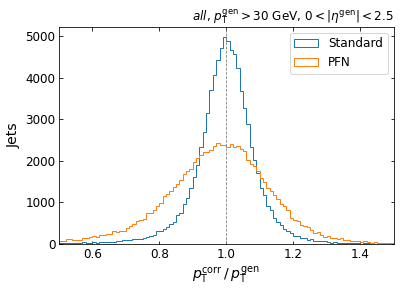

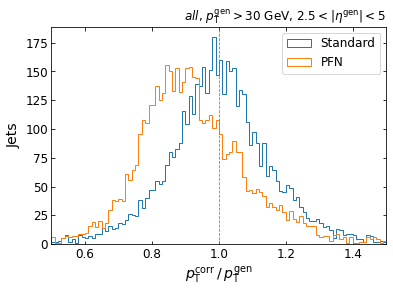

In [48]:
from utils.plot import plot_distrs

plot_distrs(df, names, os.path.join(outdir, 'distributions'))

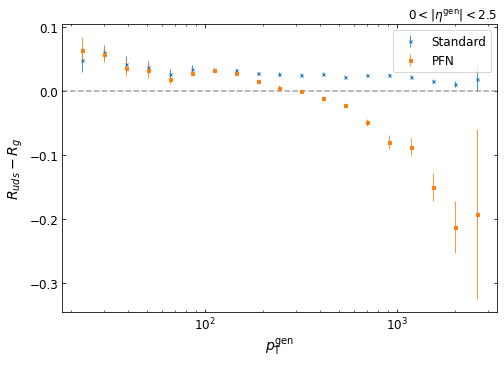

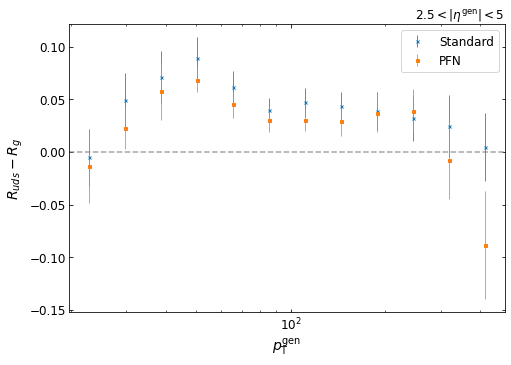

In [50]:
from utils.plot import plot_median_residual

for (ieta, eta_bin), flavours in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    itertools.combinations([('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21})], r=2),
):
    bins = []
    for i, flavour_ids in enumerate([flavours[0][1], flavours[1][1]]):
        df_bin = df[
            (np.abs(df.eta_gen) >= eta_bin[0])
            & (np.abs(df.eta_gen) < eta_bin[1])
            & df.flavour.isin(flavour_ids)
        ]
        bins.append(df_bin.groupby(pd.cut(df_bin.pt_gen, binning)))

    plot_median_residual(
        os.path.join(outdir, 'residual'),
        bin_centers, (flavours[0][0], flavours[1][0]), bins, eta_bin, ieta, names
    )